## Load Dataset

In [17]:
import pandas as pd

In [71]:
df = pd.read_csv('apt_trade_onehot.csv')

In [72]:
cols = df.columns.tolist()

In [74]:
p = cols.index('price')

In [75]:
cols = cols[:p] + cols[p+1:] + [cols[p]]

In [76]:
df = df[cols]

In [77]:
df = df.drop(columns = ['pk_apt_trade', 'pk_apt_master']) 
# x = df.drop(columns = ['price'])
# y = df['price']

## Convert to PyTorch Tensor

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [79]:
data = torch.from_numpy(df.values).float()
# x = torch.from_numpy(x.values).float()
# y = torch.from_numpy(y.values).float()
x = data[:, :1002]
y = data[:, -1:]
print(data.shape, x.shape, y.shape)

torch.Size([246111, 1003]) torch.Size([246111, 1002]) torch.Size([246111, 1])


In [81]:
# Train / Valid / Test ratio
ratios = [.6, .2, .2]

In [82]:
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

Train 147666 / Valid 49222 / Test 49223 samples.


In [83]:
indices = torch.randperm(data.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = x.split(cnts, dim=0)
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x,y):
    print(x_i.size(), y_i.size())

torch.Size([147666, 1002]) torch.Size([147666, 1])
torch.Size([49222, 1002]) torch.Size([49222, 1])
torch.Size([49223, 1002]) torch.Size([49223, 1])


## Set Hyper Parameters

In [84]:
n_epochs = 1000
batch_size = 128
print_interval = 50
early_stop = 100

## Get DataLoaders

In [85]:
from torch.utils.data import Dataset, DataLoader

In [86]:
class CustomDataset(Dataset):
    def __init__(self, data, price):
        self.data = data
        self.price = price
        super().__init__()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.price[idx]

In [87]:
train_loader = DataLoader(
    dataset = CustomDataset(x[0], y[0]),
    batch_size = batch_size,
    shuffle = True,
)
valid_loader = DataLoader(
    dataset = CustomDataset(x[1], y[1]),
    batch_size = batch_size,
    shuffle = False,
)
test_loader = DataLoader(
    dataset = CustomDataset(x[2], y[2]),
    batch_size = batch_size,
    shuffle = False,
)

print("Train %d / Valid %d / Test %d samples." % (
    len(train_loader.dataset),
    len(valid_loader.dataset),
    len(test_loader.dataset),
))

Train 147666 / Valid 49222 / Test 49223 samples.


## Build Model & Optimizer

In [96]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 512),
    nn.LeakyReLU(),
    nn.Linear(512, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 32),
    nn.LeakyReLU(),
    nn.Linear(32, 16),
    nn.LeakyReLU(),
    nn.Linear(16, 8),
    nn.LeakyReLU(),
    nn.Linear(8, 4),
    nn.LeakyReLU(),
    nn.Linear(4, y[0].size(-1)),
)

model

Sequential(
  (0): Linear(in_features=1002, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=64, out_features=32, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=32, out_features=16, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=16, out_features=8, bias=True)
  (13): LeakyReLU(negative_slope=0.01)
  (14): Linear(in_features=8, out_features=4, bias=True)
  (15): LeakyReLU(negative_slope=0.01)
  (16): Linear(in_features=4, out_features=1, bias=True)
)

In [97]:
optimizer = optim.Adam(model.parameters())

## Train

In [98]:
from copy import deepcopy
import numpy as np

lowest_loss = np.inf
best_model = None

lowest_epoch = np.inf

In [99]:
train_history, valid_history = [], []

for i in range(n_epochs):
    model.train()
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    for x_i, y_i in train_loader:
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        train_loss += float(loss)
        
    train_loss = train_loss / len(train_loader)
    
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        
        for x_i, y_i in valid_loader:
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
        
    valid_loss = valid_loss / len(valid_loader)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    if (i+1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
    
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 50: train loss=5.2894e+07  valid_loss=4.4416e+07  lowest_loss=4.3477e+07
Epoch 100: train loss=5.3231e+07  valid_loss=4.2842e+07  lowest_loss=3.9137e+07
Epoch 150: train loss=4.7975e+07  valid_loss=3.7738e+07  lowest_loss=3.3657e+07
Epoch 200: train loss=4.1550e+07  valid_loss=3.2680e+07  lowest_loss=3.2866e+07
Epoch 250: train loss=4.4679e+07  valid_loss=3.2056e+07  lowest_loss=3.1970e+07
Epoch 300: train loss=3.8531e+07  valid_loss=1.0938e+08  lowest_loss=3.1036e+07
Epoch 350: train loss=3.8755e+07  valid_loss=3.7578e+07  lowest_loss=3.0502e+07
Epoch 400: train loss=3.7441e+07  valid_loss=4.1112e+07  lowest_loss=3.0031e+07
Epoch 450: train loss=3.6211e+07  valid_loss=3.2757e+07  lowest_loss=2.9411e+07
Epoch 500: train loss=3.2920e+07  valid_loss=2.9664e+07  lowest_loss=2.8543e+07
Epoch 550: train loss=3.7979e+07  valid_loss=3.5596e+07  lowest_loss=2.8122e+07
Epoch 600: train loss=3.9919e+07  valid_loss=3.2513e+07  lowest_loss=2.8122e+07
There is no improvement during last 100 e

<All keys matched successfully>

## Load History

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

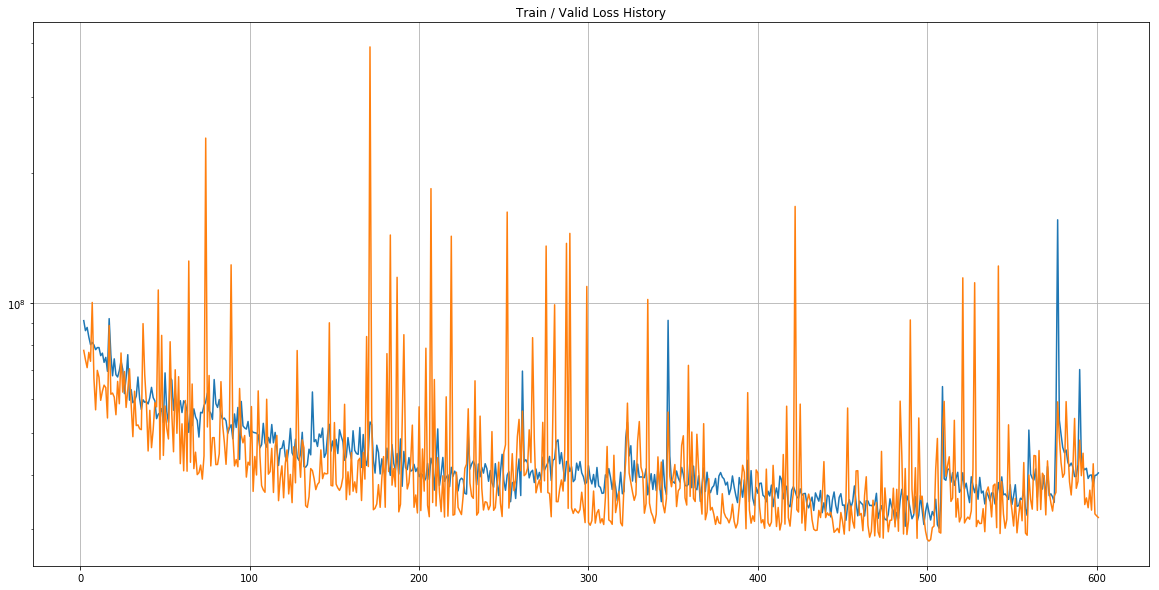

In [101]:
plot_from = 2

plt.figure(figsize = (20,10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()